<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Long Short Term Memory (LSTM)

###Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import explained_variance_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler


from keras.layers import Dense

from keras.layers import Dropout

###Define Functions to Facilitate Metrics Evaluation

In [2]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [3]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [4]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

In [5]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Plot the Target Variable

Text(0.5, 0, 'Date')

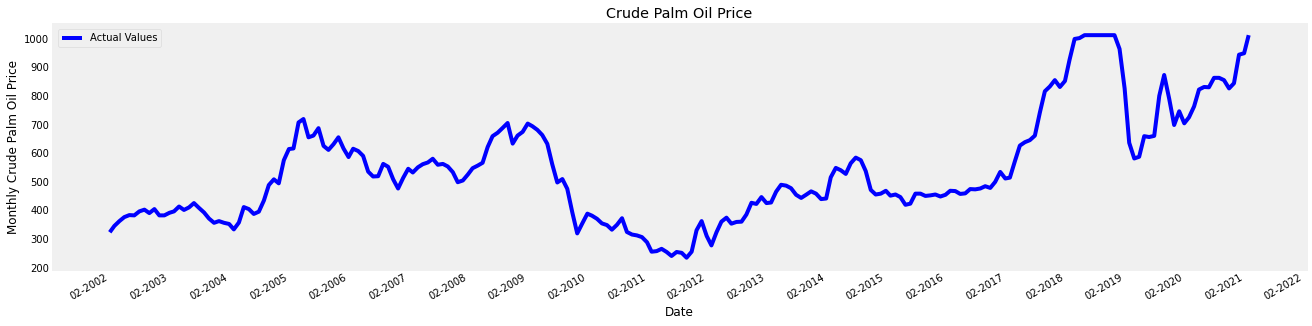

In [6]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [7]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

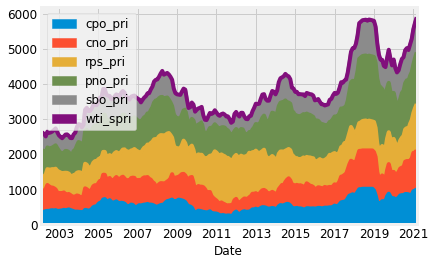

In [8]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

##**Long Term Short Forecasting Technique**

###**Split Data into Train Test Segments**

In [9]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 184
Test size: 46


In [10]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

184 46


In [11]:
print(train.shape)
train.head()

(184, 6)


,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Rescale train dataset

In [12]:
f_transformer = RobustScaler()
feature_columns = ['cpo_pri','cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,-0.801187,-0.646119,-1.324544,-0.231262,-0.442244,-0.717978
2002-03-01,-0.670623,-0.230594,-1.348516,-0.395149,-0.338987,-0.856057
2002-04-01,-0.569733,-0.006849,-1.364539,-0.690145,-0.454392,-0.936328
2002-05-01,-0.486647,0.180365,-1.351764,-1.068905,-0.600167,-0.950202
2002-06-01,-0.445104,0.646119,-1.237519,-1.050696,-0.679128,-0.928400


In [13]:
cpo_pri_transformer = RobustScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

Date
2002-02-01   -0.801187
2002-03-01   -0.670623
2002-04-01   -0.569733
2002-05-01   -0.486647
2002-06-01   -0.445104
Name: cpo_pri, dtype: float64

In [14]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2017-06-01,1.068249,0.614155,0.012901,0.597786,0.950695,-0.031877
2017-07-01,1.109792,0.760274,0.197485,0.396351,1.058264,-0.007763
2017-08-01,1.204748,0.787671,0.100871,0.537949,1.082499,-0.131968
2017-09-01,1.691395,1.057078,0.093017,0.621567,1.293083,-0.091007
2017-10-01,2.124629,1.358447,0.169917,0.953857,1.505672,-0.215212


In [15]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

Date
2017-06-01    1.068249
2017-07-01    1.109792
2017-08-01    1.204748
2017-09-01    1.691395
2017-10-01    2.124629
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [16]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(181, 3, 6) (181,)


###Create Model

####Declare input shape

In [17]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(rate=0.2))
lstm_model.add(tf.keras.layers.Dense(units=1))
lstm_model.compile(loss='mse', optimizer='adam')

###Train the lstm  model

In [18]:
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,shuffle=False)

Epoch 1/100
6/6 [==============================] - 3s 113ms/step - loss: 0.4907 - val_loss: 0.0799
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.2966 - val_loss: 0.0553
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1831 - val_loss: 0.0428
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1203 - val_loss: 0.0376
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0935 - val_loss: 0.0339
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0863 - val_loss: 0.0289
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0728 - val_loss: 0.0238
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0675 - val_loss: 0.0210
Epoch 9/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0638 - val_loss: 0.0200
Epoch 10/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0594 - val_loss: 0.0194
Epoch 11/100
6/6 [

###Model Summary

In [19]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69120     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 69,249
Trainable params: 69,249
Non-trainable params: 0
_________________________________________________________________


###Predict the Test Data

In [20]:
y_pred = lstm_model.predict(X_test)
y_pred

array([[1.1780727 ],
       [1.3969896 ],
       [1.6913638 ],
       [1.8289145 ],
       [1.9665856 ],
       [1.9922342 ],
       [2.0662591 ],
       [2.1344302 ],
       [2.152865  ],
       [2.1294267 ],
       [2.1195846 ],
       [2.1421278 ],
       [2.1501448 ],
       [2.1336844 ],
       [2.0875156 ],
       [2.0593357 ],
       [2.033345  ],
       [1.9201784 ],
       [1.513468  ],
       [0.94891113],
       [0.55046505],
       [0.5332996 ],
       [0.9861764 ],
       [1.1563712 ],
       [1.2039125 ],
       [1.7038552 ],
       [2.161567  ],
       [2.0778997 ],
       [1.71787   ],
       [1.8118968 ],
       [1.7266347 ],
       [1.7539667 ],
       [1.8851359 ],
       [2.0194407 ],
       [2.0441647 ],
       [2.0663931 ],
       [2.1878216 ],
       [2.2508073 ],
       [2.1633449 ],
       [2.0237598 ],
       [2.048645  ],
       [2.3237505 ],
       [2.4414222 ]], dtype=float32)

###Inverte Transformed Data

In [21]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[-0.48664688 -0.44510386 -0.45103858 -0.36795252 -0.33234421 -0.40356083
  -0.32047478 -0.45103858 -0.45103858 -0.39762611 -0.36795252 -0.26706231
  -0.33827893 -0.28486647 -0.1958457  -0.29673591 -0.39169139 -0.51632047
  -0.60534125 -0.56973294 -0.60534125 -0.62908012 -0.74183976 -0.59940653
  -0.27893175 -0.32047478 -0.42136499 -0.37388724 -0.14243323  0.17804154
   0.29673591  0.21364985  0.69436202  0.92581602  0.93768546  1.47774481
   1.54896142  1.16913947  1.20474777  1.35905045  0.99109792  0.90801187
   1.02670623  1.16913947  0.93768546  0.75964392  0.93175074  0.884273
   0.78338279  0.45697329  0.35608309  0.3620178   0.61721068  0.5578635
   0.29673591  0.10682493  0.3264095   0.51632047  0.43916914  0.54599407
   0.61127596  0.64688427  0.72403561  0.59940653  0.61721068  0.56379822
   0.44510386  0.23738872  0.27299703  0.39762611  0.52818991  0.58160237
   0.64094955  0.96735905  1.19287834  1.26409496  1.36498516  1.46587537
   1.03857567  1.20474777  1.28189911  1.

###Plot History, Actual and Predicted Value

In [22]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([-0.48664688, -0.44510386, -0.45103858, -0.36795252, -0.33234421,
       -0.40356083, -0.32047478, -0.45103858, -0.45103858, -0.39762611,
       -0.36795252, -0.26706231, -0.33827893, -0.28486647, -0.1958457 ,
       -0.29673591, -0.39169139, -0.51632047, -0.60534125, -0.56973294,
       -0.60534125, -0.62908012, -0.74183976, -0.59940653, -0.27893175,
       -0.32047478, -0.42136499, -0.37388724, -0.14243323,  0.17804154,
        0.29673591,  0.21364985,  0.69436202,  0.92581602,  0.93768546,
        1.47774481,  1.54896142,  1.16913947,  1.20474777,  1.35905045,
        0.99109792,  0.90801187,  1.02670623,  1.16913947,  0.93768546,
        0.75964392,  0.93175074,  0.884273  ,  0.78338279,  0.45697329,
        0.35608309,  0.3620178 ,  0.61721068,  0.5578635 ,  0.29673591,
        0.10682493,  0.3264095 ,  0.51632047,  0.43916914,  0.54599407,
        0.61127596,  0.64688427,  0.72403561,  0.59940653,  0.61721068,
        0.56379822,  0.44510386,  0.23738872,  0.27299703,  0.39

In [23]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([1.69139466, 2.12462908, 2.22551929, 2.35608309, 2.21364985,
       2.33827893, 2.77744807, 3.21068249, 3.22848665, 3.28931751,
       3.28931751, 3.28931751, 3.28931751, 3.28931751, 3.28931751,
       3.28931751, 3.00296736, 2.18397626, 1.05637982, 0.72997033,
       0.76557864, 1.19287834, 1.17507418, 1.19881306, 2.02967359,
       2.46290801, 1.96439169, 1.42433234, 1.70919881, 1.45994065,
       1.58456973, 1.81008902, 2.16023739, 2.21364985, 2.20771513,
       2.40356083, 2.40356083, 2.35608309, 2.18397626, 2.29080119,
       2.884273  , 2.91394659, 3.28931751])

In [24]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([1.1780727 , 1.3969896 , 1.6913638 , 1.8289145 , 1.9665856 ,
       1.9922342 , 2.0662591 , 2.1344302 , 2.152865  , 2.1294267 ,
       2.1195846 , 2.1421278 , 2.1501448 , 2.1336844 , 2.0875156 ,
       2.0593357 , 2.033345  , 1.9201784 , 1.513468  , 0.94891113,
       0.55046505, 0.5332996 , 0.9861764 , 1.1563712 , 1.2039125 ,
       1.7038552 , 2.161567  , 2.0778997 , 1.71787   , 1.8118968 ,
       1.7266347 , 1.7539667 , 1.8851359 , 2.0194407 , 2.0441647 ,
       2.0663931 , 2.1878216 , 2.2508073 , 2.1633449 , 2.0237598 ,
       2.048645  , 2.3237505 , 2.4414222 ], dtype=float32)

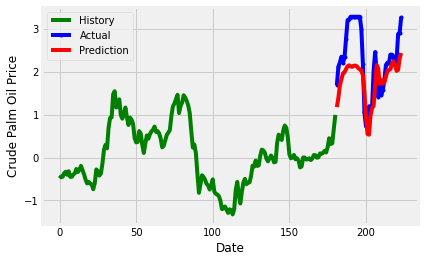

In [27]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Date')
plt.legend()
plt.show();